<a href="https://colab.research.google.com/github/ragul-n/Gender-bias-in-Indian-movies/blob/master/word2vec/calculating_bias_measure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U fse
!pip install --upgrade scipy 
!pip install --upgrade numpy

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies_data=pd.read_csv("https://github.com/ragul-n/Gender-bias-in-Indian-cinema/blob/78bc1bff5a0bd14ba94220f63d2b383d1a963df9/Data%20Collection/data/indian%20movies.csv?raw=true")
movies_data["Year"]= movies_data.Year.str.extract("(\d{4})").loc[:,0]
movies_data["Year"]=[float(i) for i in movies_data.Year]
movies_data=movies_data.set_index("ID")
movies_data.head()

,Movie Name,Year,Timing(min),Rating(10),Votes,Genre,Language
ID,,,,,,,
tt0398974,Dr. Shaitan,1960.0,-,-,-,-,hindi
tt1702558,Nadir Khan,1968.0,-,-,-,-,urdu
tt0493437,Apna Sapna Money Money,2006.0,134 min,5.3,"1,892","Comedy, Musical, Romance",hindi
tt0273405,Aag Aur Sholay,1987.0,-,2.2,20,-,urdu
tt0049595,Parivar,1956.0,-,7.4,21,"Comedy, Drama, Family",hindi


### Dictionary Generation

In [3]:
career_polarity= pd.read_csv("/content/drive/MyDrive/Dataset/word2vec/polarity_career_vs_family_v4.csv",index_col=0, names=["score"]).score
intelligence_polarity=pd.read_csv("/content/drive/MyDrive/Dataset/word2vec/polarity_appearance_vs_intelligence_v1.csv",index_col=0, names=["score"]).score

career_polarity= (career_polarity - career_polarity.mean())/career_polarity.std()
career_polarity= career_polarity[(career_polarity>2) | (career_polarity<-2)]

intelligence_polarity= (intelligence_polarity - intelligence_polarity.mean())/intelligence_polarity.std()
intelligence_polarity= intelligence_polarity[(intelligence_polarity>2) | (intelligence_polarity<-2)]


In [4]:
from gensim.models import KeyedVectors

word_vectors= KeyedVectors.load("/content/drive/MyDrive/Dataset/word2vec/subtitles_word_emb_v6.word_vectors")

In [5]:

target_words=['queen', 'wife', 'woman', 'ladi', 'bride', 'femal',
'goddess', 'feminin', 'she', 'sister', 'madonna',  'womanhood', 'mother','babe']


In [6]:
associated_words= []
for target_word in target_words:
    n_similar_words= word_vectors.similar_by_word(target_word, topn=100)

    for word, score in n_similar_words:
        associated_words.append(word)

In [7]:
career_dictionary= set(associated_words) & set(career_polarity.index)
intelligence_dictionary= set(associated_words) & set(intelligence_polarity.index)

In [8]:
career_vector= np.zeros(200)
intelligence_vector=np.zeros(200)

for word in career_dictionary:
    career_vector= career_vector + career_polarity[word]*word_vectors[word]
for word in intelligence_dictionary:
    intelligence_vector= intelligence_vector + intelligence_polarity[word]*word_vectors[word]

### Estimating Subtitle Embeddings and Angular Distance (Bias Measure) Calculation 

In [9]:
from fse.models import SIF

model= SIF.load("/content/drive/MyDrive/Dataset/word2vec/subtitles_fse.model")


In [10]:
from fse import IndexedList
import os
import tqdm 

def read_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    sents=[line.split() for line in lines]
    return sents

def angular_distance(v1, v2):
  v1_normalized = v1 / np.linalg.norm(v1)
  v2_normalized = v2 / np.linalg.norm(v2)
  return np.arccos(np.clip(np.dot(v1_normalized, v2_normalized), -1.0, 1.0))

def estimate_document_vector(sents):
    indexed_sents=IndexedList(sents)
    sents_vector= model.infer(indexed_sents)

    doc_vector= np.add.reduce(sents_vector) - model.svd_res[1][0]

    return doc_vector

folder_path='/content/drive/MyDrive/Dataset/processed_subtitles/'

career_distance, intelligence_distance={},{}

for filename in tqdm.tqdm(os.listdir(folder_path)):
    sents= read_file(folder_path+filename)

    subtitle_vector = estimate_document_vector(sents)
    career=angular_distance(career_vector, subtitle_vector)
    intell=angular_distance(intelligence_vector, subtitle_vector)

    career_distance[filename[:9]]=career
    intelligence_distance[filename[:9]]=intell

    

100%|██████████| 4168/4168 [02:20<00:00, 29.76it/s]


### Data Analysis

In [11]:
movies_data["career"]=pd.Series(career_distance)
movies_data["intelligence"]=pd.Series(intelligence_distance)


In [12]:
data=movies_data[~ movies_data.career.isna()].copy()
data=data[data.Language.isin(["hindi","tamil","malayalam","telugu","kannada","punjabi","bengali"])].copy()

data["career"]=(data.career- data.career.min())/(data.career.max() - data.career.min())
data["intelligence"]=(data.intelligence- data.intelligence.min())/(data.intelligence.max() - data.intelligence.min())

data=data[(data.Year>=1990) & (data.Year<=2019)]
data["Year"]=data.Year.astype("int64")


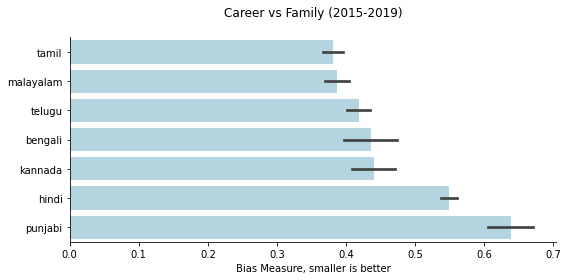

In [13]:

fig, ax= plt.subplots(figsize=(8,4))
fig.patch.set_visible(False)

ax=sns.barplot(data=data[data.Year>=2015], y="Language", x="career",color="lightblue",
                            order=["tamil", "malayalam","telugu","bengali","kannada","hindi","punjabi"], ax=ax)

plt.xlabel("Bias Measure, smaller is better")

#ax.tick_params(left=False, labelleft=False)
# for bars_group in ax.containers:
#     ax.bar_label(bars_group, padding=3, fontsize=15)

sns.despine() 
ax.set(ylabel=None, title="Career vs Family (2015-2019)\n")
plt.tight_layout()


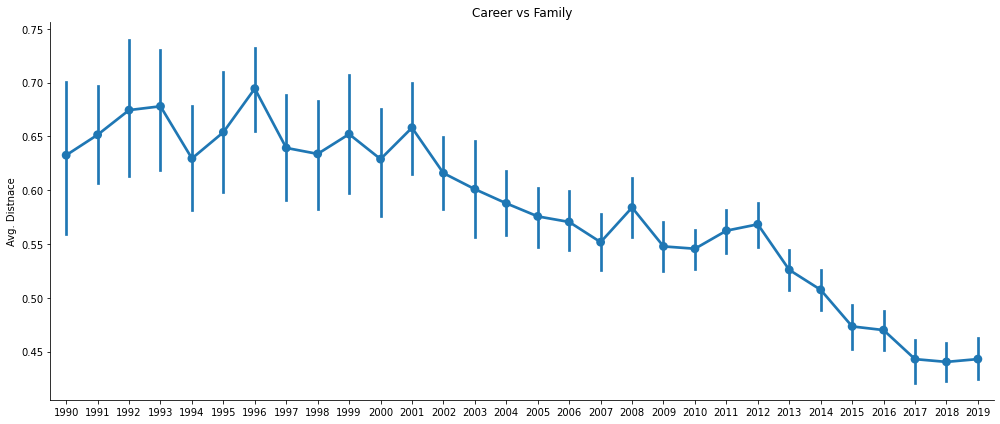

In [14]:
fig, ax= plt.subplots(figsize=(14,6))

sns.pointplot(data=data[data.Year>=1990], y="career",x="Year", ci=95)

sns.despine()
ax.set(title="Career vs Family",xlabel=None, ylabel="Avg. Distnace")
plt.tight_layout()

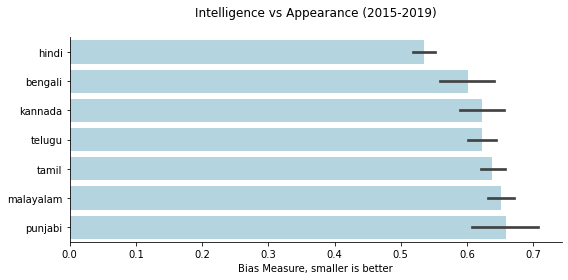

In [15]:
fig, ax= plt.subplots(figsize=(8,4))
fig.patch.set_visible(False)

ax=sns.barplot(data=data[data.Year>=2015], y="Language", x="intelligence",color="lightblue",
                            order=["hindi","bengali","kannada","telugu","tamil", "malayalam","punjabi"], ax=ax)

plt.xlabel("Bias Measure, smaller is better")

#ax.tick_params(left=False, labelleft=False)
# for bars_group in ax.containers:
#     ax.bar_label(bars_group, padding=3, fontsize=15)

sns.despine() 
ax.set(ylabel=None, title="Intelligence vs Appearance (2015-2019)\n")
plt.tight_layout()


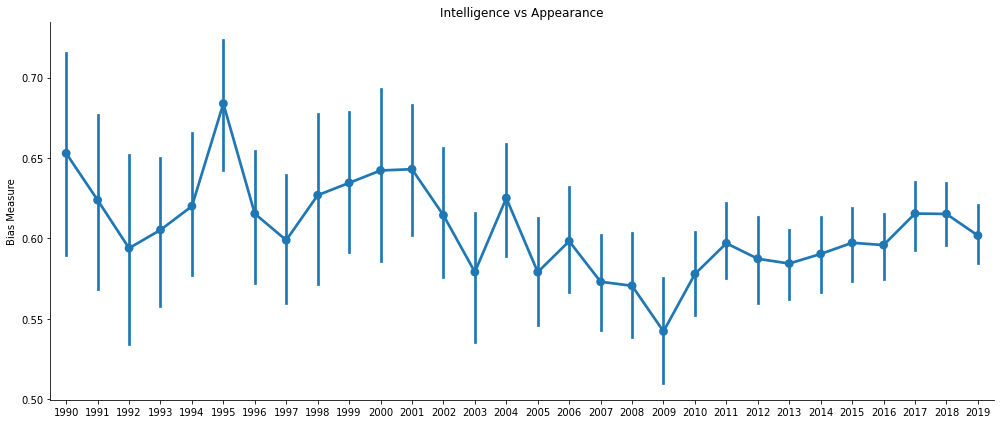

In [17]:
fig, ax= plt.subplots(figsize=(14,6))

sns.pointplot(data=data[data.Year>=1990], y="intelligence",x="Year", ci=95)

sns.despine()
ax.set(title="Intelligence vs Appearance",xlabel=None, ylabel="Bias Measure")
plt.tight_layout()

In [57]:
data["career"]["tt5200962"] #tt5200962 -> kathalum kadathu pogum 

0.33773783252127876

In [19]:
#Top 40 movies by career vs family
data.sort_values('career')[:40]

,Movie Name,Year,Timing(min),Rating(10),Votes,Genre,Language,career,intelligence
ID,,,,,,,,,
tt9447594,The Gambler,2019,121 min,5.3,59,"Action, Sci-Fi, Thriller",malayalam,0.000000,0.753054
tt2002868,Anegan,2015,154 min,6.7,"2,996","Action, Romance, Thriller",tamil,0.009816,0.796646
tt4882642,Naalu Policeum Nalla Irundha Oorum,2015,-,5.3,113,Comedy,tamil,0.045515,0.820200
tt5147626,Chaayam Poosiya Veedu,2015,101 min,5.0,76,"Drama, Mystery",malayalam,0.054329,0.877136
tt7019942,Super Deluxe,2019,176 min,8.3,"10,541","Comedy, Crime, Drama",tamil,0.068657,0.579679
tt7535730,Projapoti Biskut,2017,116 min,6.6,375,"Comedy, Drama",bengali,0.074956,0.731769
tt8413338,Kumbalangi Nights,2019,135 min,8.6,"9,899","Comedy, Drama, Romance",malayalam,0.075585,0.773565
tt8142712,Pornomochi,2018,117 min,6.5,198,"Crime, Drama",bengali,0.077966,0.812433
tt7125262,Shamantakamani,2017,130 min,6.9,421,Drama,telugu,0.079024,0.768921


In [22]:
#Top 40 movies by Intelligence vs Appearance
data.sort_values('intelligence')[:40]

,Movie Name,Year,Timing(min),Rating(10),Votes,Genre,Language,career,intelligence
ID,,,,,,,,,
tt2283748,OMG: Oh My God!,2012,125 min,8.1,"52,431","Comedy, Drama, Fantasy",hindi,0.462397,0.030840
tt1508950,Baabarr,2009,180 min,5.1,301,"Action, Crime, Drama",hindi,0.467401,0.035806
tt3590416,Global Baba,2016,120 min,5.6,182,Thriller,hindi,0.528028,0.043034
tt4354740,Dharam Sankat Mein,2015,129 min,6.3,"2,091",Comedy,hindi,0.537288,0.047862
tt1065099,My Friend Ganesha,2007,190 min,4.6,149,Animation,hindi,0.401370,0.049289
tt1607568,Lava Kusa: The Warrior Twins,2010,120 min,6.5,31,Animation,telugu,0.581096,0.053352
tt1607568,Lava Kusa: The Warrior Twins,2010,120 min,6.5,31,Animation,tamil,0.581096,0.053352
tt2397561,Shirdi Sai,2012,145 min,6.8,242,"Biography, Drama, Musical",telugu,0.444476,0.073328
tt7757972,Saakshyam,2018,166 min,4.7,437,Action,telugu,0.504559,0.077607
